In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow.keras as keras
from utils import set_seed
from plot_utils import plot_eval_results

set_seed()


In [2]:

from mnist_utils import plot_samples
from config import cfg
from vanilla_model import fit as fit_vanilla
from metrics import calc_metrics
from converters import Converter
from config import cfg
from eval import run_tflite_model
from c_utils import write_model_h
from utils import save_test_data
import plot_utils as pu
from model import get_model
from model import save_pruned_model
from utils import get_gzipped_model_size

In [3]:
from nyuv2_torch_ds_adapter import get_tf_nyuv2_ds
import argparse
args = argparse.Namespace()
args.truncate_testset = False
# args.target_size = (64, 64)
args.crop_size = (640, 480)
# args.target_size = (64, 64)
args.target_size = cfg.img_size
args.out_fold_ratio = 1
args.is_maxim = False
cfg.do_overfit=False
args.batch_size=cfg.batch_size*4

ds_train, ds_val, ds_test = get_tf_nyuv2_ds(cfg.base_kitti_dataset_dir, args)
# train_size=cfg.take_first_n
# ds_train = ds_train.take(train_size)
# val_size=cfg.take_first_n
# ds_val = ds_val.take(val_size)
# test_size=cfg.take_first_n
# ds_test = ds_test.take(test_size)

x_val= next(iter(ds_val))
x_train= next(iter(ds_train))

Dataset: NYU Depth V2
# of train images: 50688
Dataset: NYU Depth V2
# of test images: 654
Train size:  40551
Val size:  10137
Test size:  654


In [4]:
x_train[0].numpy().max(), x_train[0].numpy().min(), x_train[1].numpy().max(), x_train[1].numpy().min(), 

(1.0, 0.0, 0.254, 0.018)

Text(0.5, 1.0, 'Depth')

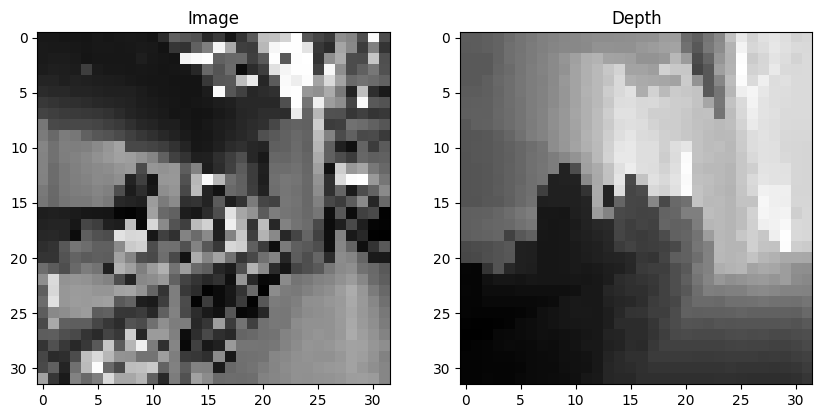

In [5]:
fig, axs = plt.subplots(1, 2, figsize=(10, 5))
axs[0].imshow(x_train[0][0].numpy())
axs[1].imshow(x_train[1][0].numpy())
axs[0].set_title('Image')
axs[1].set_title('Depth')

In [6]:
import os
converter = Converter(cfg)

# cfg.save_model_dir = "/tmp/models"
# cfg.save_cfiles_dir = "/tmp/cfiles"
# cfg.save_test_data_dir = "/tmp/test_data"
# cfg.do_overfit = True

os.makedirs(cfg.save_model_dir, exist_ok=True)
os.makedirs(cfg.save_cfiles_dir, exist_ok=True)
os.makedirs(cfg.save_test_data_dir, exist_ok=True)

In [7]:
model_names = [
    "depth_model_quant8_dynR",
    "depth_full_quant",
    "depth_qat_int8",
    "pruned_model",
    "pruned_model_unstructured",
    "pruned_model_unstructured_dynamic",
    "pruned_qat_model",
    "depth_model_fp32",
]
cfiles = {
    "depth_model_quant8_dynR": "depth_model_quant8_dynR",
    "depth_full_quant": "q8depth",
    "depth_qat_int8": "qat8depth",
    "pruned_model": "pruned",
    "pruned_model_unstructured": "pruned_unstructured",
    "pruned_model_unstructured_dynamic": "pruned_unstructured_dynamic",
    "pruned_qat_model": "pruned_unstructured_qat_model",
    "depth_model_fp32": "depth_model_fp32",
}
save_test_data(cfg.save_test_data_dir, x_train[0], x_train[1])

Test image data location:  /media/master/wext/msc_studies/second_semester/microcontrollers/project/stm32/code/test_data/x_test_depth.npy
Test labels location:  /media/master/wext/msc_studies/second_semester/microcontrollers/project/stm32/code/test_data/y_test_depth.npy


In [8]:
import pickle
from eval import eval_model
from loss import calculate_loss
from model import get_model
import tensorflow_model_optimization as tfmot


def fit_eval(model, model_name, do_save_model=True, epochs=cfg.epochs, do_savefig=True):
    keras.backend.clear_session()
    # loss = tf.keras.losses.MeanSquaredError()
    metrics = tf.keras.metrics.Mean(name="loss")

    # Define a custom metric
    def custom_metric(y_true, y_pred, sample_weight=None):
        metric_value = calculate_loss(y_true, y_pred)
        metrics.update_state(metric_value, sample_weight=sample_weight)
        return metric_value

    optimizer = tf.keras.optimizers.Adam(learning_rate=0.0005)

    model.compile(optimizer=optimizer, loss="mae", metrics=[custom_metric])

    reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
        monitor="loss", factor=0.2, min_lr=1e-7, patience=5, min_delta=1e-2, verbose=1
    )
    callbacks = [reduce_lr]
    if "pruned" in model_name:
        callbacks.append(tfmot.sparsity.keras.UpdatePruningStep())
    if not cfg.do_overfit:
        tbCallBack = tf.keras.callbacks.TensorBoard(
            log_dir=f"{cfg.logdir}/tb_logs",
            histogram_freq=0,
            write_graph=False,
            write_images=False,
        )
        es = tf.keras.callbacks.EarlyStopping(
            patience=cfg.es_patience, restore_best_weights=True,
            min_delta=5e-3, 
            monitor="loss",
        )
        model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
            filepath=cfg.logdir + f"/{model_name}",
            save_weights_only=True,
            monitor="custom_metric",
            mode="min",
            save_best_only=True,
        )
        callbacks.append(es)
        callbacks.append(model_checkpoint_callback)
        callbacks.append(tbCallBack)
    history = model.fit(
        x=ds_train,
        epochs=epochs,
        validation_data=ds_val,
        callbacks=callbacks,
        verbose=1,
    )
    # pickle history
    with open(f"{cfg.save_model_dir}/{model_name}_history.pkl", "wb") as f:
        pickle.dump(history.history, f)

    # plot history
    pu.plot_history(history, f"{cfg.save_model_dir}/{model_name}_history.png")
    if not do_savefig:
        plt.show()
    tflite_path=None
    model_tflite=None
    if do_save_model:
        model.save(f"{cfg.save_model_dir}/{model_name}.h5")
        model_tflite, tflite_path = converter.keras_to_tflite(model, model_name, do_return_path=True)
    # tflite_path='/tmp/models/depth_model_fp32.tflite'
    metrics = eval_model(
        model=model,
        test_ds=ds_val,
        tflite_path=tflite_path,
        model_name=model_name,
        metrics_file_path=f"{cfg.save_model_dir}/metrics.json",
    )
    return model_tflite, metrics, history

In [9]:
# load history
# with open(f"{cfg.save_model_dir}/{model_names[7]}_history.pkl", "rb") as f:
#     history2 = pickle.load(f)
# pu.plot_history(history2, f"{cfg.save_model_dir}/{model_names[7]}_history.png")

Epoch 1/50
16/16 [==============================] - 19s 1s/step - loss: 0.1681 - custom_metric: 0.7624 - val_loss: 0.3095 - val_custom_metric: 0.6154 - lr: 5.0000e-04
Epoch 2/50
16/16 [==============================] - 16s 1s/step - loss: 0.0723 - custom_metric: 0.7697 - val_loss: 0.2212 - val_custom_metric: 0.5581 - lr: 5.0000e-04
Epoch 3/50
16/16 [==============================] - 16s 1s/step - loss: 0.0706 - custom_metric: 0.7290 - val_loss: 0.1426 - val_custom_metric: 0.4498 - lr: 5.0000e-04
Epoch 4/50
16/16 [==============================] - 16s 1s/step - loss: 0.0678 - custom_metric: 0.6692 - val_loss: 0.1294 - val_custom_metric: 0.4464 - lr: 5.0000e-04
Epoch 5/50
16/16 [==============================] - 16s 1s/step - loss: 0.0646 - custom_metric: 0.6103 - val_loss: 0.1341 - val_custom_metric: 0.4659 - lr: 5.0000e-04
Epoch 6/50
16/16 [==============================] - 16s 1s/step - loss: 0.0608 - custom_metric: 0.5448 - val_loss: 0.1351 - val_custom_metric: 0.4579 - lr: 5.0000e-0

INFO:tensorflow:Assets written to: /tmp/tmpkib54xbs/assets


INFO:tensorflow:Assets written to: /tmp/tmpkib54xbs/assets


Model was saved at location: /media/master/wext/msc_studies/second_semester/microcontrollers/project/stm32/code/models/depth_model_fp32.tflite
HDF5 Model size: 1142 KB
TFLite Model size: 300 KB

Reduction in file size by a factor of 3.796482


INFO: Created TensorFlow Lite XNNPACK delegate for CPU.


Evaluated on 100 images.
Evaluated on 200 images.
Evaluated on 300 images.
Evaluated on 400 images.
Evaluated on 500 images.
Evaluated on 600 images.
Evaluated on 700 images.
Evaluated on 800 images.
Evaluated on 900 images.
Evaluated on 1000 images.
Evaluated on 1100 images.
Evaluated on 1200 images.
Evaluated on 1300 images.
Evaluated on 1400 images.
Evaluated on 1500 images.
Evaluated on 1600 images.
Evaluated on 1700 images.
Evaluated on 1800 images.
Evaluated on 1900 images.
depth_model_fp32 model metrics:
mse: 0.003
mae: 0.051
eval_loss: 0.051
eval_metric: 0.189
Saved metrics to /media/master/wext/msc_studies/second_semester/microcontrollers/project/stm32/code/models/metrics.json


INFO:tensorflow:Assets written to: /tmp/tmpntmte_na/assets


INFO:tensorflow:Assets written to: /tmp/tmpntmte_na/assets


Model was saved at location: /media/master/wext/msc_studies/second_semester/microcontrollers/project/stm32/code/models/depth_model_fp32.tflite
HDF5 Model size: 1142 KB
TFLite Model size: 300 KB

Reduction in file size by a factor of 3.796482


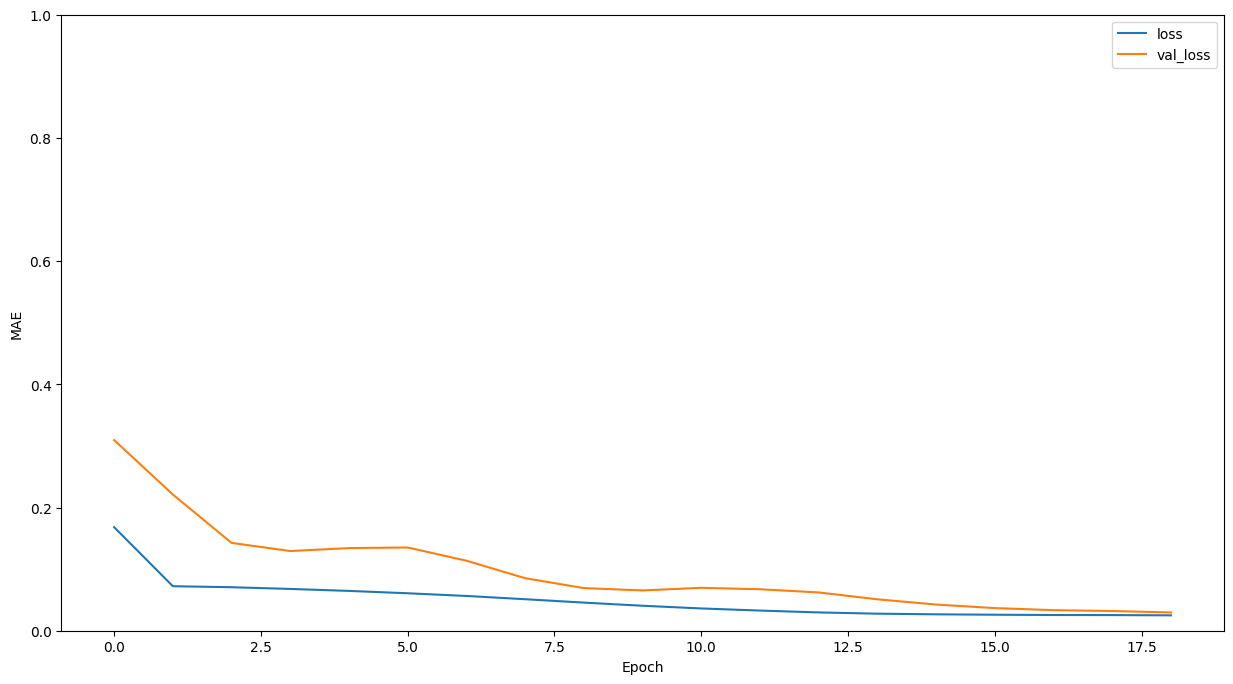

In [10]:
# Build model
keras.backend.clear_session()
fp_model = get_model(
    cfg.img_size, cfg.num_classes, in_channels=cfg.in_channels, use_qat=False,
    do_downsample_model=True
)
fit_eval(fp_model, model_names[7], epochs=cfg.epochs)
model_tflite, tflite_path = converter.keras_to_tflite(fp_model, model_names[7], do_return_path=True)
write_model_h(cfiles[model_names[7]], model_tflite, cfg.save_cfiles_dir)

1/1 [==============================] - 0s 273ms/step
MAE: 0.05, RMSE: 0.00, loss: 0.21


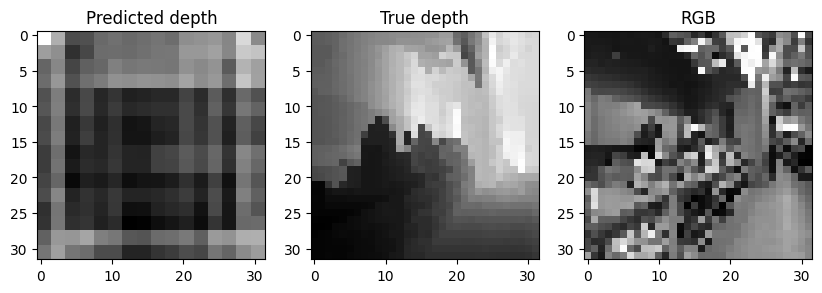

In [11]:

out = fp_model.predict(x_train[0][0][None, ...])
plot_eval_results(out[0], x_train[1][0], x_train[0][0])

In [12]:
dynR_quant_tflite_model = converter.dynamic_range_quantization(fp_model, model_names[0])

INFO:tensorflow:Assets written to: /tmp/tmpe_g_rp6d/assets


INFO:tensorflow:Assets written to: /tmp/tmpe_g_rp6d/assets


Model was saved at location: /media/master/wext/msc_studies/second_semester/microcontrollers/project/stm32/code/models/depth_model_quant8_dynR.tflite


In [13]:
tflite_model_quant_int8=converter.eight_bit_quantization(fp_model, ds_train, model_name=model_names[1])
converter.check_quantized_model(tflite_model_quant_int8)

INFO:tensorflow:Assets written to: /tmp/tmpsqiqcmio/assets


INFO:tensorflow:Assets written to: /tmp/tmpsqiqcmio/assets
/home/master/.conda/envs/sc/lib/python3.9/site-packages/tensorflow/lite/python/convert.py:765: UserWarning: Statistics for quantized inputs were expected, but not specified; continuing anyway.
  warnings.warn("Statistics for quantized inputs were expected, but not "


Model was saved at location: /media/master/wext/msc_studies/second_semester/microcontrollers/project/stm32/code/models/depth_full_quant.tflite
TFLite Model size with 8-bit quantization: 108 KB
TFLite Model size without quantization: 300 KB

Reduction in model size by a factor of 2.783861
input:  <class 'numpy.uint8'>
output:  <class 'numpy.uint8'>


fully_quantize: 0, inference_type: 6, input_inference_type: UINT8, output_inference_type: UINT8


In [14]:
depth_full_quant_tflite_path=f'{cfg.save_model_dir}/{model_names[1]}.tflite'
eval_model(
        ds_val,
        tflite_path=depth_full_quant_tflite_path,
        model=None,
        model_name=model_names[1],
        metrics_file_path=f"{cfg.save_model_dir}/metrics.json",
    )
write_model_h(cfiles[model_names[1]], tflite_model_quant_int8, cfg.save_cfiles_dir)

Evaluated on 100 images.
Evaluated on 200 images.
Evaluated on 300 images.
Evaluated on 400 images.
Evaluated on 500 images.
Evaluated on 600 images.
Evaluated on 700 images.
Evaluated on 800 images.
Evaluated on 900 images.
Evaluated on 1000 images.
Evaluated on 1100 images.
Evaluated on 1200 images.
Evaluated on 1300 images.
Evaluated on 1400 images.
Evaluated on 1500 images.
Evaluated on 1600 images.
Evaluated on 1700 images.
Evaluated on 1800 images.
Evaluated on 1900 images.
depth_full_quant model metrics:
mse: 863.325
mae: 29.169
eval_loss: -1.000
eval_metric: -1.000
Saved metrics to /media/master/wext/msc_studies/second_semester/microcontrollers/project/stm32/code/models/metrics.json


Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


Epoch 1/50
16/16 [==============================] - 19s 1s/step - loss: 0.0727 - custom_metric: 0.7156 - val_loss: 0.2337 - val_custom_metric: 0.5426 - lr: 5.0000e-04
Epoch 2/50
16/16 [==============================] - 16s 1s/step - loss: 0.0628 - custom_metric: 0.6481 - val_loss: 0.1081 - val_custom_metric: 0.3436 - lr: 5.0000e-04
Epoch 3/50
16/16 [==============================] - 16s 1s/step - loss: 0.0515 - custom_metric: 0.5001 - val_loss: 0.0938 - val_custom_metric: 0.3198 - lr: 5.0000e-04
Epoch 4/50
16/16 [==============================] - 16s 1s/step - loss: 0.0418 - custom_metric: 0.3416 - val_loss: 0.1478 - val_custom_metric: 0.4453 - lr: 5.0000e-04
Epoch 5/50
16/16 [==============================] - 16s 1s/step - loss: 0.0346 - custom_metric: 0.2182 - val_loss: 0.1910 - val_custom_metric: 0.5271 - lr: 5.0000e-04
Epoch 6/50
16/16 [==============================] - 16s 1s/step - loss: 0.0298 - custom_metric: 0.1623 - val_loss: 0.2157 - val_custom_metric: 0.5597 - lr: 5.0000e-0

Model was saved at location: /media/master/wext/msc_studies/second_semester/microcontrollers/project/stm32/code/models/depth_qat_int8.tflite
HDF5 Model size: 1294 KB
TFLite Model size: 643 KB

Reduction in file size by a factor of 2.012106
Evaluated on 100 images.
Evaluated on 200 images.
Evaluated on 300 images.
Evaluated on 400 images.
Evaluated on 500 images.
Evaluated on 600 images.
Evaluated on 700 images.
Evaluated on 800 images.
Evaluated on 900 images.
Evaluated on 1000 images.
Evaluated on 1100 images.
Evaluated on 1200 images.
Evaluated on 1300 images.
Evaluated on 1400 images.
Evaluated on 1500 images.
Evaluated on 1600 images.
Evaluated on 1700 images.
Evaluated on 1800 images.
Evaluated on 1900 images.
depth_qat_int8 model metrics:
mse: 0.044
mae: 0.200
eval_loss: 0.200
eval_metric: 0.543
Saved metrics to /media/master/wext/msc_studies/second_semester/microcontrollers/project/stm32/code/models/metrics.json


/home/master/.conda/envs/sc/lib/python3.9/site-packages/tensorflow/lite/python/convert.py:765: UserWarning: Statistics for quantized inputs were expected, but not specified; continuing anyway.
  warnings.warn("Statistics for quantized inputs were expected, but not "


Model was saved at location: /media/master/wext/msc_studies/second_semester/microcontrollers/project/stm32/code/models/depth_qat_int8.tflite
TFLite Model size with 8-bit quantization: 108 KB
TFLite Model size without quantization: 300 KB

Reduction in model size by a factor of 2.781850


fully_quantize: 0, inference_type: 6, input_inference_type: UINT8, output_inference_type: UINT8


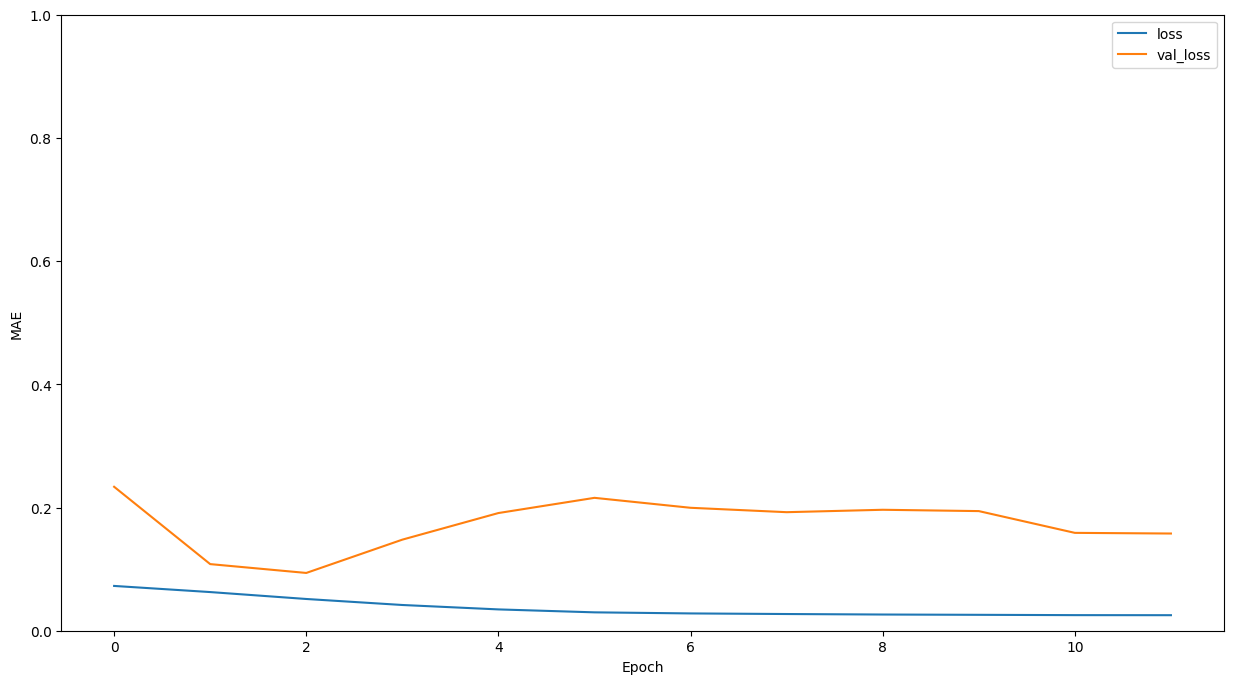

In [15]:
# Convert the model to a quantization aware model
quant_aware_model = get_model(
    cfg.img_size, cfg.num_classes, in_channels=cfg.in_channels, use_qat=True
)
model_name = model_names[2]
fit_eval(quant_aware_model, model_name)
quant_aware_model_converted = converter.eight_bit_quantization(
    quant_aware_model, ds_train, model_name=model_name
)
write_model_h(cfiles[model_name], quant_aware_model_converted, cfg.save_cfiles_dir)

Epoch 1/50
16/16 [==============================] - 22s 1s/step - loss: 0.3765 - custom_metric: 0.8885 - val_loss: 0.1781 - val_custom_metric: 0.4822 - lr: 5.0000e-04
Epoch 2/50
16/16 [==============================] - 16s 1s/step - loss: 0.1819 - custom_metric: 0.8207 - val_loss: 0.1331 - val_custom_metric: 0.4140 - lr: 5.0000e-04
Epoch 3/50
16/16 [==============================] - 16s 1s/step - loss: 0.0856 - custom_metric: 0.7649 - val_loss: 0.0792 - val_custom_metric: 0.2916 - lr: 5.0000e-04
Epoch 4/50
16/16 [==============================] - 16s 1s/step - loss: 0.0721 - custom_metric: 0.7835 - val_loss: 0.0619 - val_custom_metric: 0.2461 - lr: 5.0000e-04
Epoch 5/50
16/16 [==============================] - 16s 1s/step - loss: 0.0710 - custom_metric: 0.7574 - val_loss: 0.0648 - val_custom_metric: 0.2620 - lr: 5.0000e-04
Epoch 6/50
16/16 [==============================] - 16s 1s/step - loss: 0.0694 - custom_metric: 0.7264 - val_loss: 0.0769 - val_custom_metric: 0.2976 - lr: 5.0000e-0

Saved pruned Keras model to: /media/master/wext/msc_studies/second_semester/microcontrollers/project/stm32/code/models/pruned_model.h5


INFO:tensorflow:Assets written to: /tmp/tmpwligetbu/assets


INFO:tensorflow:Assets written to: /tmp/tmpwligetbu/assets


Model was saved at location: /media/master/wext/msc_studies/second_semester/microcontrollers/project/stm32/code/models/pruned_model.tflite
HDF5 Model size: 431 KB
TFLite Model size: 300 KB

Reduction in file size by a factor of 1.434413


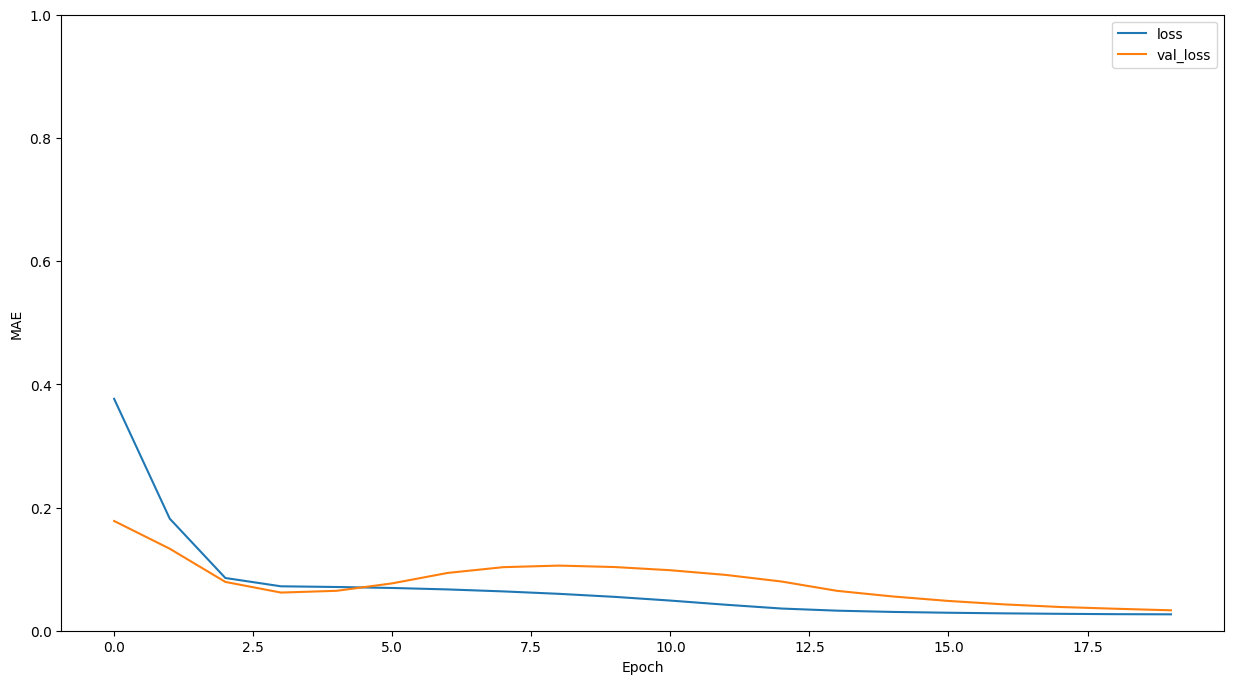

In [16]:
model_name = model_names[3]
pruned_model = get_model(cfg.img_size, cfg.num_classes, in_channels=cfg.in_channels, use_qat=False, use_pruning=True,
                         use_pruning_struct=True)
fit_eval(pruned_model, model_name, do_save_model=False)
pruned_model_for_export = save_pruned_model(pruned_model, f"{cfg.save_model_dir}/{model_name}.h5")
pruned_tflite_model = converter.keras_to_tflite(pruned_model_for_export, model_name)
write_model_h(cfiles[model_name], pruned_tflite_model, cfg.save_cfiles_dir)

Epoch 1/50
16/16 [==============================] - 22s 1s/step - loss: 0.1099 - custom_metric: 0.7405 - val_loss: 0.2768 - val_custom_metric: 0.5717 - lr: 5.0000e-04
Epoch 2/50
16/16 [==============================] - 16s 1s/step - loss: 0.0711 - custom_metric: 0.6083 - val_loss: 0.2606 - val_custom_metric: 0.5494 - lr: 5.0000e-04
Epoch 3/50
16/16 [==============================] - 16s 1s/step - loss: 0.0604 - custom_metric: 0.5719 - val_loss: 0.1954 - val_custom_metric: 0.4863 - lr: 5.0000e-04
Epoch 4/50
16/16 [==============================] - 16s 1s/step - loss: 0.0518 - custom_metric: 0.4609 - val_loss: 0.1925 - val_custom_metric: 0.4854 - lr: 5.0000e-04
Epoch 5/50
16/16 [==============================] - 16s 1s/step - loss: 0.0441 - custom_metric: 0.3454 - val_loss: 0.1759 - val_custom_metric: 0.4635 - lr: 5.0000e-04
Epoch 6/50
16/16 [==============================] - 16s 1s/step - loss: 0.0382 - custom_metric: 0.2703 - val_loss: 0.1358 - val_custom_metric: 0.3942 - lr: 5.0000e-0

Saved pruned Keras model to: /media/master/wext/msc_studies/second_semester/microcontrollers/project/stm32/code/models/pruned_model_unstructured.h5


INFO:tensorflow:Assets written to: /tmp/tmp_7akcc6x/assets


INFO:tensorflow:Assets written to: /tmp/tmp_7akcc6x/assets


Model was saved at location: /media/master/wext/msc_studies/second_semester/microcontrollers/project/stm32/code/models/pruned_model_unstructured.tflite
HDF5 Model size: 431 KB
TFLite Model size: 300 KB

Reduction in file size by a factor of 1.434413
Evaluated on 100 images.
Evaluated on 200 images.
Evaluated on 300 images.
Evaluated on 400 images.
Evaluated on 500 images.
Evaluated on 600 images.
Evaluated on 700 images.
Evaluated on 800 images.
Evaluated on 900 images.
Evaluated on 1000 images.
Evaluated on 1100 images.
Evaluated on 1200 images.
Evaluated on 1300 images.
Evaluated on 1400 images.
Evaluated on 1500 images.
Evaluated on 1600 images.
Evaluated on 1700 images.
Evaluated on 1800 images.
Evaluated on 1900 images.
pruned_model_unstructured model metrics:
mse: 0.002
mae: 0.036
eval_loss: 0.036
eval_metric: 0.142
Saved metrics to /media/master/wext/msc_studies/second_semester/microcontrollers/project/stm32/code/models/metrics.json


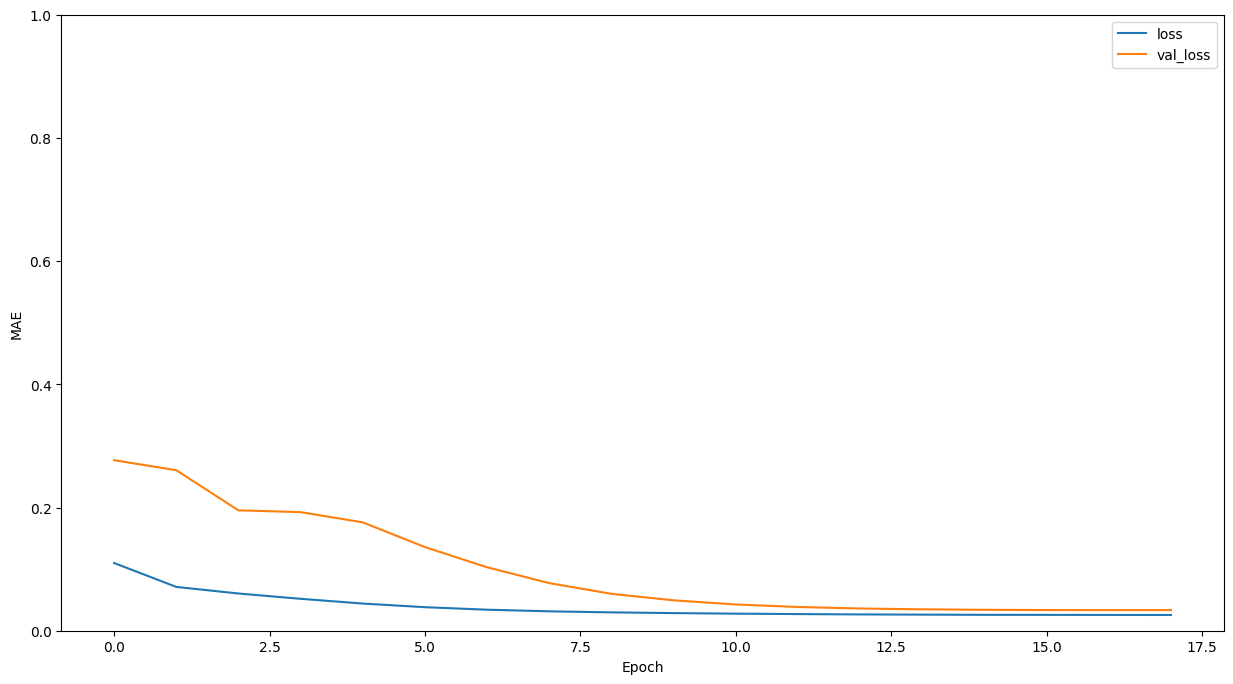

In [17]:
model_name = model_names[4]
pruned_model_unstruct = get_model(
    cfg.img_size,
    cfg.num_classes,
    in_channels=cfg.in_channels,
    use_qat=False,
    use_pruning=True,
    use_pruning_struct=False,
    use_dynamic_sparsity=False,
)
fit_eval(pruned_model_unstruct, model_name, do_save_model=False)
pruned_model_for_export = save_pruned_model(
    pruned_model_unstruct, f"{cfg.save_model_dir}/{model_name}.h5"
)
pruned_tflite_model = converter.keras_to_tflite(pruned_model_for_export, model_name)
eval_model(
        model=pruned_model_unstruct,
        test_ds=ds_val,
        tflite_path=f"{cfg.save_model_dir}/{model_name}.tflite",
        model_name=model_name,
        metrics_file_path=f"{cfg.save_model_dir}/metrics.json",
    )
write_model_h(cfiles[model_name], pruned_tflite_model, cfg.save_cfiles_dir)

Epoch 1/50
16/16 [==============================] - 22s 1s/step - loss: 0.0800 - custom_metric: 0.7593 - val_loss: 0.2408 - val_custom_metric: 0.5345 - lr: 5.0000e-04
Epoch 2/50
16/16 [==============================] - 16s 1s/step - loss: 0.1010 - custom_metric: 0.6054 - val_loss: 0.2592 - val_custom_metric: 0.5467 - lr: 5.0000e-04
Epoch 3/50
16/16 [==============================] - 16s 1s/step - loss: 0.0589 - custom_metric: 0.5551 - val_loss: 0.1857 - val_custom_metric: 0.4642 - lr: 5.0000e-04
Epoch 4/50
16/16 [==============================] - 16s 1s/step - loss: 0.0548 - custom_metric: 0.5166 - val_loss: 0.1343 - val_custom_metric: 0.3851 - lr: 5.0000e-04
Epoch 5/50
16/16 [==============================] - 16s 1s/step - loss: 0.0523 - custom_metric: 0.4305 - val_loss: 0.0609 - val_custom_metric: 0.2090 - lr: 5.0000e-04
Epoch 6/50
16/16 [==============================] - 16s 1s/step - loss: 0.0422 - custom_metric: 0.3184 - val_loss: 0.0455 - val_custom_metric: 0.1637 - lr: 5.0000e-0

Saved pruned Keras model to: /media/master/wext/msc_studies/second_semester/microcontrollers/project/stm32/code/models/pruned_model_unstructured_dynamic.h5


INFO:tensorflow:Assets written to: /tmp/tmpe7e9k_ya/assets


INFO:tensorflow:Assets written to: /tmp/tmpe7e9k_ya/assets


Model was saved at location: /media/master/wext/msc_studies/second_semester/microcontrollers/project/stm32/code/models/pruned_model_unstructured_dynamic.tflite
HDF5 Model size: 431 KB
TFLite Model size: 300 KB

Reduction in file size by a factor of 1.434413
Evaluated on 100 images.
Evaluated on 200 images.
Evaluated on 300 images.
Evaluated on 400 images.
Evaluated on 500 images.
Evaluated on 600 images.
Evaluated on 700 images.
Evaluated on 800 images.
Evaluated on 900 images.
Evaluated on 1000 images.
Evaluated on 1100 images.
Evaluated on 1200 images.
Evaluated on 1300 images.
Evaluated on 1400 images.
Evaluated on 1500 images.
Evaluated on 1600 images.
Evaluated on 1700 images.
Evaluated on 1800 images.
Evaluated on 1900 images.
pruned_model_unstructured_dynamic model metrics:
mse: 0.003
mae: 0.046
eval_loss: 0.046
eval_metric: 0.163
Saved metrics to /media/master/wext/msc_studies/second_semester/microcontrollers/project/stm32/code/models/metrics.json


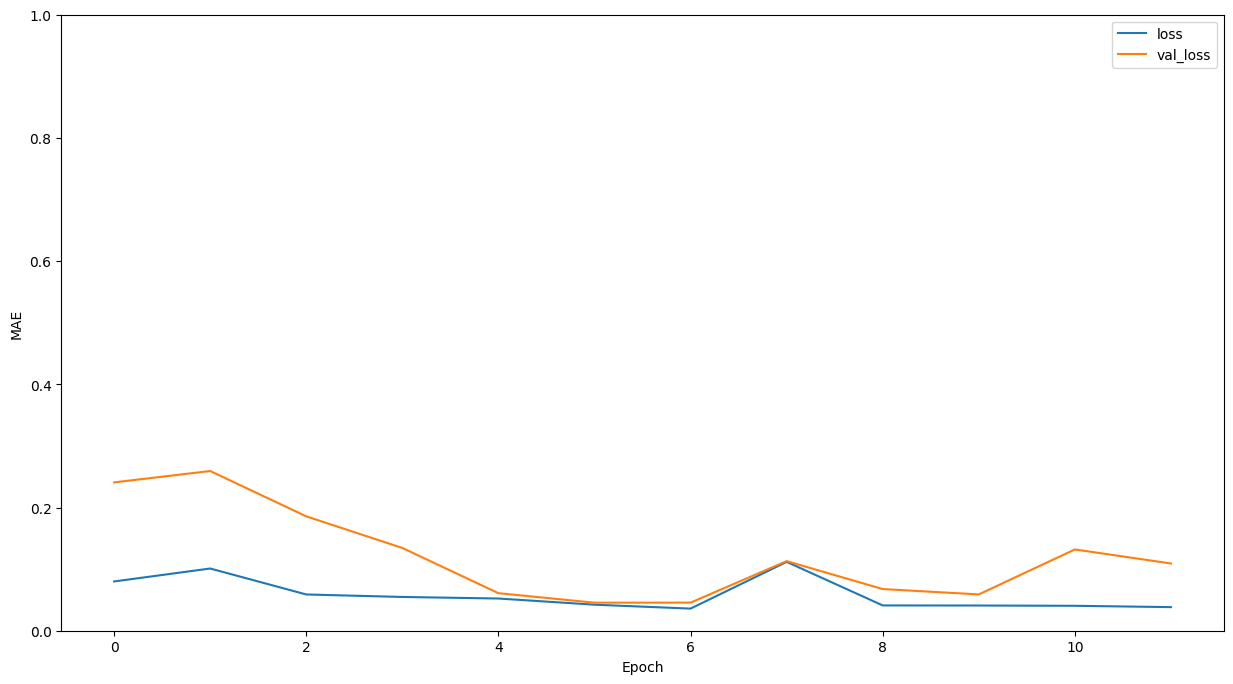

In [18]:
model_name = model_names[5]
pruned_model_unstruct_dynamic = get_model(
    cfg.img_size,
    cfg.num_classes,
    in_channels=cfg.in_channels,
    use_qat=False,
    use_pruning=True,
    use_pruning_struct=False,
    use_dynamic_sparsity=True,
)
fit_eval(pruned_model_unstruct_dynamic, model_name, do_save_model=False)
pruned_model_unstructured_for_export = save_pruned_model(
    pruned_model_unstruct_dynamic, f"{cfg.save_model_dir}/{model_name}.h5"
)
pruned_tflite_model = converter.keras_to_tflite(pruned_model_unstructured_for_export, model_name)
eval_model(
        model=pruned_model_unstruct_dynamic,
        test_ds=ds_val,
        tflite_path=f"{cfg.save_model_dir}/{model_name}.tflite",
        model_name=model_name,
        metrics_file_path=f"{cfg.save_model_dir}/metrics.json",
    )
write_model_h(cfiles[model_name], pruned_tflite_model, cfg.save_cfiles_dir)

Epoch 1/50
16/16 [==============================] - 20s 1s/step - loss: 0.0325 - custom_metric: 0.2021 - val_loss: 0.0610 - val_custom_metric: 0.2089 - lr: 5.0000e-04
Epoch 2/50
16/16 [==============================] - 16s 1s/step - loss: 0.0276 - custom_metric: 0.1462 - val_loss: 0.0549 - val_custom_metric: 0.1946 - lr: 5.0000e-04
Epoch 3/50
16/16 [==============================] - 16s 1s/step - loss: 0.0259 - custom_metric: 0.1259 - val_loss: 0.0491 - val_custom_metric: 0.1776 - lr: 5.0000e-04
Epoch 4/50
16/16 [==============================] - 16s 1s/step - loss: 0.0249 - custom_metric: 0.1156 - val_loss: 0.0432 - val_custom_metric: 0.1620 - lr: 5.0000e-04
Epoch 5/50
16/16 [==============================] - 16s 1s/step - loss: 0.0243 - custom_metric: 0.1094 - val_loss: 0.0391 - val_custom_metric: 0.1488 - lr: 5.0000e-04
Epoch 6/50
16/16 [==============================] - ETA: 0s - loss: 0.0236 - custom_metric: 0.1045
Epoch 6: ReduceLROnPlateau reducing learning rate to 0.00010000000

Saved pruned Keras model to: /media/master/wext/msc_studies/second_semester/microcontrollers/project/stm32/code/models/pruned_qat_model.h5


Model was saved at location: /media/master/wext/msc_studies/second_semester/microcontrollers/project/stm32/code/models/pruned_qat_model.tflite
HDF5 Model size: 587 KB
TFLite Model size: 643 KB

Reduction in file size by a factor of 0.913258
Evaluated on 100 images.
Evaluated on 200 images.
Evaluated on 300 images.
Evaluated on 400 images.
Evaluated on 500 images.
Evaluated on 600 images.
Evaluated on 700 images.
Evaluated on 800 images.
Evaluated on 900 images.
Evaluated on 1000 images.
Evaluated on 1100 images.
Evaluated on 1200 images.
Evaluated on 1300 images.
Evaluated on 1400 images.
Evaluated on 1500 images.
Evaluated on 1600 images.
Evaluated on 1700 images.
Evaluated on 1800 images.
Evaluated on 1900 images.
pruned_qat_model model metrics:
mse: 0.003
mae: 0.049
eval_loss: 0.049
eval_metric: 0.178
Saved metrics to /media/master/wext/msc_studies/second_semester/microcontrollers/project/stm32/code/models/metrics.json


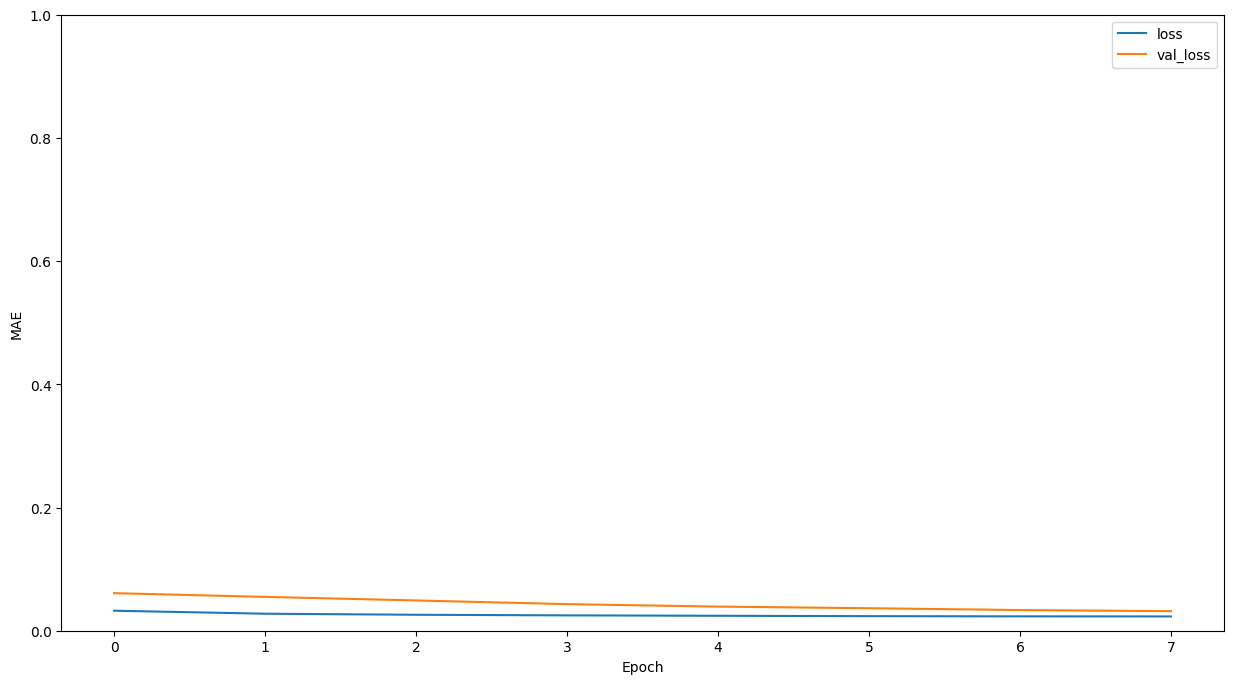

In [19]:
model_name = model_names[6]
pruned_qat_model = get_model(
    cfg.img_size,
    cfg.num_classes,
    in_channels=cfg.in_channels,
    use_qat=True,
    use_pruning=True,
    use_pruning_struct=False,
    use_dynamic_sparsity=False,
    pruned_model_unstructured_for_export=pruned_model_unstructured_for_export
)
fit_eval(pruned_qat_model, model_name, do_save_model=False)
pruned_model_for_export = save_pruned_model(
    pruned_qat_model, f"{cfg.save_model_dir}/{model_name}.h5"
)
pruned_tflite_model = converter.keras_to_tflite(pruned_model_for_export, model_name)
eval_model(
        model=pruned_qat_model,
        test_ds=ds_val,
        tflite_path=f"{cfg.save_model_dir}/{model_name}.tflite",
        model_name=model_name,
        metrics_file_path=f"{cfg.save_model_dir}/metrics.json",
    )
write_model_h(cfiles[model_name], pruned_tflite_model, cfg.save_cfiles_dir)